In [1]:
import qstock
import numpy as np
import pandas as pd

# 510300：沪深300ETF，代表大盘
# 510500：中证500ETF，代表小盘
# 510880：红利ETF，代表价值
# 159915：创业板ETF，代表成长
pool_list = ['510300', '510500', '510880', '159915']
start_date = '20130729'
data = qstock.get_price(pool_list, start=start_date, freq='d', fqt=1).sort_index()
name_list = data.columns.tolist()
data.head(10)

/home/baochunhui/.conda/envs/yubaoCtrader/lib/python3.11/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


,红利ETF,创业板ETF,中证500ETF,沪深300ETF
date,,,,
2013-07-29,0.375,1.124,2.818,1.497
2013-07-30,0.394,1.110,2.803,1.510
2013-07-31,0.399,1.122,2.821,1.515
2013-08-01,0.428,1.177,2.905,1.574
2013-08-02,0.423,1.169,2.912,1.570
2013-08-05,0.437,1.193,2.965,1.603
2013-08-06,0.446,1.196,2.996,1.618
2013-08-07,0.435,1.162,2.955,1.602
2013-08-08,0.429,1.171,2.961,1.603


In [2]:
# 动量长度
N = 20
# 计算每日涨跌幅和N日涨跌幅
for name in name_list:
    data['日收益率_'+name] = data[name] / data[name].shift(1) - 1.0
    data['涨幅_'+name] = data[name] / data[name].shift(N+1) - 1.0
# 去掉缺失值
data = data.dropna()
data[['涨幅_'+v for v in name_list]].head(10)

,涨幅_红利ETF,涨幅_创业板ETF,涨幅_中证500ETF,涨幅_沪深300ETF
date,,,,
2013-08-27,0.352000,0.093416,0.091909,0.112224
2013-08-28,0.263959,0.089189,0.090974,0.095364
2013-08-29,0.243108,0.075758,0.084013,0.087129
2013-08-30,0.156542,-0.005098,0.040964,0.043837
2013-09-02,0.179669,0.023952,0.040522,0.047771
2013-09-03,0.205950,0.017603,0.042833,0.048659
2013-09-04,0.179372,0.015886,0.031041,0.038319
2013-09-05,0.204598,0.074010,0.051777,0.042447
2013-09-06,0.251748,0.077711,0.058088,0.050530


In [3]:
# 取出每日涨幅最大的证券
data['信号'] = data[['涨幅_'+v for v in name_list]].idxmax(axis=1).str.replace('涨幅_', '')
# 今日的涨幅由昨日的持仓产生
data['信号'] = data['信号'].shift(1)
data = data.dropna()
data['轮动策略日收益率'] = data.apply(lambda x: x['日收益率_'+x['信号']], axis=1) 
# 第一天尾盘交易，当日涨幅不纳入
data.loc[data.index[0],'轮动策略日收益率'] = 0.0
data['轮动策略净值'] = (1.0 + data['轮动策略日收益率']).cumprod()
data[['涨幅_'+v for v in name_list]+['信号','轮动策略日收益率','轮动策略净值']].head(10)

,涨幅_红利ETF,涨幅_创业板ETF,涨幅_中证500ETF,涨幅_沪深300ETF,信号,轮动策略日收益率,轮动策略净值
date,,,,,,,
2013-08-28,0.263959,0.089189,0.090974,0.095364,红利ETF,0.000000,1.000000
2013-08-29,0.243108,0.075758,0.084013,0.087129,红利ETF,-0.004016,0.995984
2013-08-30,0.156542,-0.005098,0.040964,0.043837,红利ETF,-0.002016,0.993976
2013-09-02,0.179669,0.023952,0.040522,0.047771,红利ETF,0.008081,1.002008
2013-09-03,0.205950,0.017603,0.042833,0.048659,红利ETF,0.056112,1.058233
2013-09-04,0.179372,0.015886,0.031041,0.038319,红利ETF,-0.001898,1.056225
2013-09-05,0.204598,0.074010,0.051777,0.042447,红利ETF,-0.003802,1.052209
2013-09-06,0.251748,0.077711,0.058088,0.050530,红利ETF,0.024809,1.078313
2013-09-09,0.505855,0.080965,0.060799,0.099194,红利ETF,0.197393,1.291165


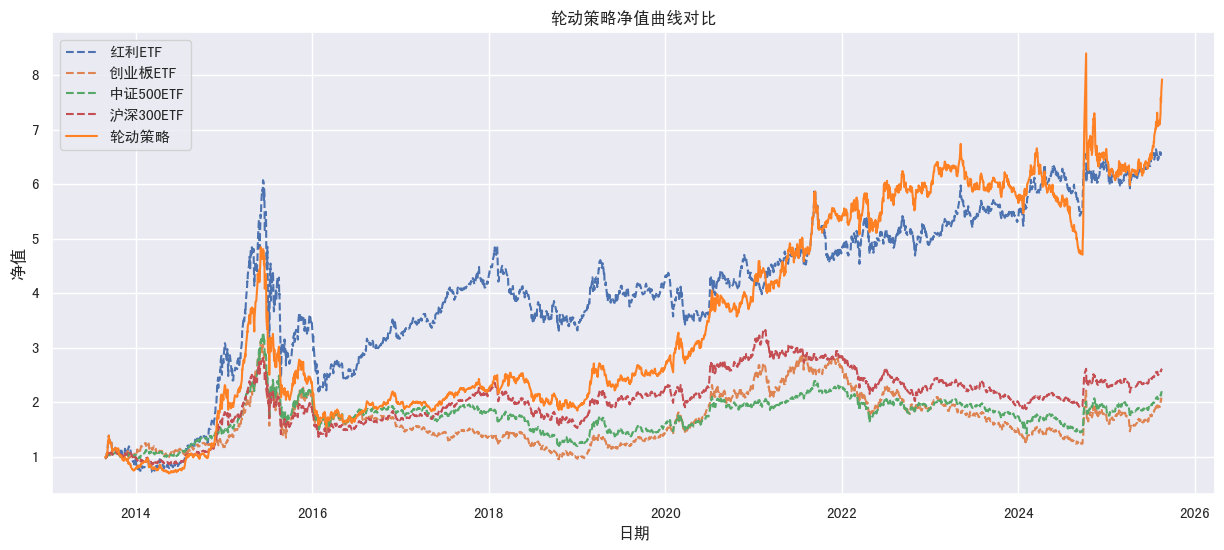

In [4]:
import matplotlib.pyplot as plt

# 显示中文设置
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

# 绘制净值曲线图
fig, ax = plt.subplots(figsize=(15, 6))
ax.set_xlabel('日期')
ax.set_ylabel('净值')
for name in name_list+['轮动策略']:
    if name in name_list:
        data[name+'净值'] = data[name]/data[name].iloc[0]
        ax.plot(data[name+'净值'].index, data[name+'净值'].values, linestyle='--')
    else:
        ax.plot(data[name+'净值'].index, data[name+'净值'].values, linestyle='-', color='#FF8124')

# 显示图例和标题
ax.legend(name_list+['轮动策略'])
ax.set_title('轮动策略净值曲线对比')

plt.show()

In [5]:
import matplotlib.pyplot as plt

# 指定字体（例如：黑体SimHei，若系统中没有可替换为其他中文字体）
plt.rcParams["font.family"] = ["SimHei"]
plt.rcParams['font.sans-serif'] = ['SimHei']

/home/baochunhui/.conda/envs/yubaoCtrader/lib/python3.11/site-packages/quantstats/_plotting/core.py:558: UserWarning: Glyph 27818 (\N{CJK UNIFIED IDEOGRAPH-6CAA}) missing from current font.
  fig.tight_layout()
/home/baochunhui/.conda/envs/yubaoCtrader/lib/python3.11/site-packages/quantstats/_plotting/core.py:558: UserWarning: Glyph 28145 (\N{CJK UNIFIED IDEOGRAPH-6DF1}) missing from current font.
  fig.tight_layout()
/home/baochunhui/.conda/envs/yubaoCtrader/lib/python3.11/site-packages/quantstats/_plotting/core.py:558: UserWarning: Glyph 20928 (\N{CJK UNIFIED IDEOGRAPH-51C0}) missing from current font.
  fig.tight_layout()
/home/baochunhui/.conda/envs/yubaoCtrader/lib/python3.11/site-packages/quantstats/_plotting/core.py:558: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  fig.tight_layout()
/home/baochunhui/.conda/envs/yubaoCtrader/lib/python3.11/site-packages/quantstats/_plotting/core.py:565: UserWarning: Glyph 27818 (\N{CJK UNIFIED IDEOGRAPH-

                     Benchmark    Strategy
-------------------  -----------  ----------
Start Period         2013-08-29   2013-08-29
End Period           2025-08-18   2025-08-18
Risk-Free Rate       0.0%         0.0%
Time in Market       99.0%        99.0%

Cumulative Return    161.61%      692.09%
CAGR﹪               8.71%        19.69%

Sharpe               0.45         0.71
Prob. Sharpe Ratio   93.51%       99.2%
Sortino              0.64         1.04
Sortino/√2           0.45         0.74
Omega                1.15         1.15

Max Drawdown         -51.58%      -68.07%
Max DD Date          2016-01-28   2016-02-29
Max DD Period Start  2015-06-09   2015-06-04
Max DD Period End    2020-11-06   2021-05-28
Longest DD Days      1978         2186

Gain/Pain Ratio      0.09         0.15
Gain/Pain (1M)       0.47         0.79

Payoff Ratio         1.04         1.08
Profit Factor        1.09         1.15
Common Sense Ratio   1.25         1.29
CPC Index            0.58         0.64
Tail Ratio

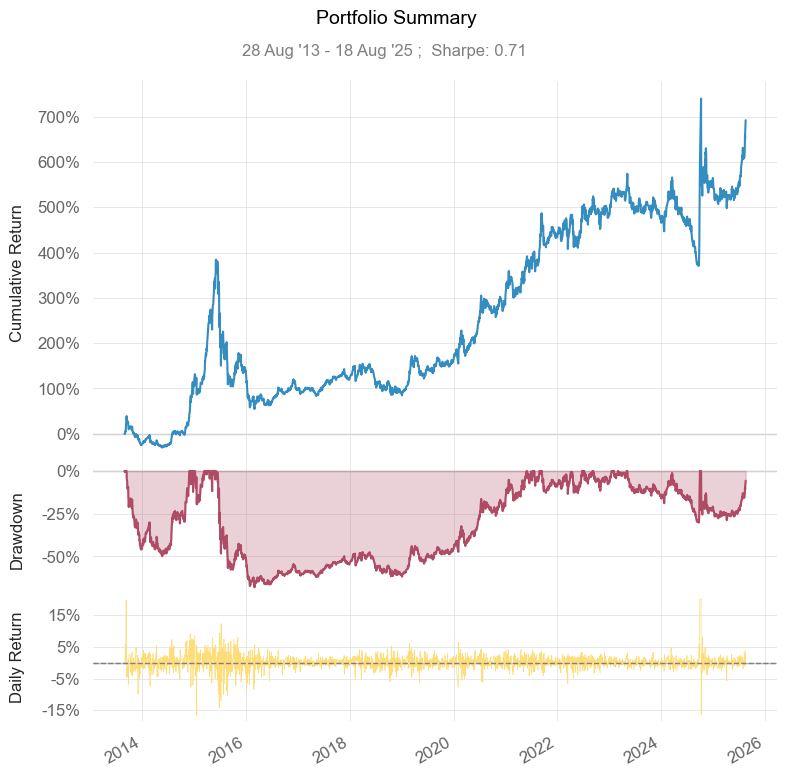

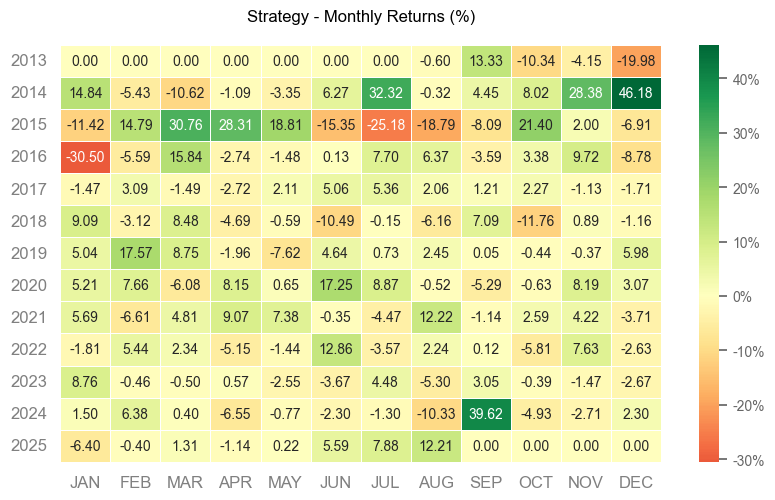

In [6]:
import matplotlib.pyplot as plt

# 指定字体（例如：黑体SimHei，若系统中没有可替换为其他中文字体）
plt.rcParams["font.family"] = ["SimHei"]
plt.rcParams['font.sans-serif'] = ['SimHei']

import quantstats as qstat

#将完整回测报告存为HTML文件
qstat.reports.html(data['轮动策略净值'], benchmark=data['沪深300ETF净值'],
                  title='轮动策略回测报告',
                  download_filename='轮动策略回测报告.html') 
#输出基本回测报告信息
qstat.reports.basic(data['轮动策略净值'], benchmark=data['沪深300ETF净值'])